# Pruebas de regresión

A la hora realizar predicciones es extremadamente importante saber
cómo de fiable es el modelo que se está utilizando por lo que realizar pruebas
es completamente necesario.

## Dataset

Debido a que no se posee históricos de los datos de los sensores y ya
que PRTG sólo recopila datos cuando está conectado en un equipo en
funcionamiento, los datasets empleados para realizar las pruebas no son
lo suficientemente extensos cómo para entrenar el modelo y que saque
predicciones fidedignas.
Por ello, se realizarán las pruebas con datos recogidos en intervalos de
varias de horas y se comprobará cómo se comporta el algoritmo a corto
plazo.
Para estas pruebas se usarán dos de los sensores, el que mide la presión
de la tubería de agua y el que mide el consumo de la bomba de agua.

## Código

Se declaran algunas clases utilizadas en el proyecto para simular un sistema real.

In [1]:
from river import compose
from river import linear_model
from river import preprocessing
import math
from river import optim
from river import time_series

import os
import sys

from datetime import date
from datetime import datetime
from dateutil.relativedelta import relativedelta

import abc
from abc import ABC
import json

import csv
import numpy as np                               # vectors and matrices
import pandas as pd 

from datetime import date
from datetime import datetime
from dateutil.relativedelta import relativedelta

from math import sqrt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from river import utils
from enum import Enum

import matplotlib.pyplot as plt

In [2]:
class Modelo(ABC):

    def __init__(self, idSensor):
        self.idSensor = idSensor

    @abc.abstractmethod
    def inicializar(self):
        return

    @abc.abstractmethod
    def entrenar(self, datos):
        return

    @abc.abstractmethod
    def predecir(self, minutos):
        return

    def _get_ordinal_date(x):
        return {'ordinal_date': x.hour * 60 + x.minute + x.toordinal()}

In [3]:
class Metricas_Regresion:


    def RMSE(valores, predicciones):       
        return sqrt(mean_squared_error(valores, predicciones))
    
    def MAE(valores, predicciones):
        return mean_absolute_error(valores, predicciones)
    
    def MSE(valores, predicciones):
        return mean_squared_error(valores, predicciones)

    def R2(valores, predicciones):
        return r2_score(valores, predicciones)

In [4]:
class Modelo_SNARIMAX(Modelo):

    def __init__(self, idSensor):
        Modelo.__init__(self, idSensor)
        self.tipo = "SNARIMAX"
        
        
    def inicializar(self, p = 0, d = 0, q = 0, m = 1, sp = 0, sq = 0, intercept_init = 0, sgd = 0, intercerpt_lr = 0):
        self.p = p
        self.d = d
        self.q = q
        self.m = m
        self.sp = sp
        self.sq = sq

        self.intercept_init = intercept_init
        self.sgd = sgd
        self.intercerpt_lr = intercerpt_lr

        extract_features = compose.TransformerUnion(
            Modelo._get_ordinal_date,
        )

        model = (
            extract_features |
            time_series.SNARIMAX(
                p=self.p,
                d=self.d,
                q=self.q,
                m=self.m,
                sp=self.sp,
                sq=self.sq,
                regressor=(
                    preprocessing.StandardScaler() |
                    linear_model.LinearRegression(
                        intercept_init= self.intercept_init,
                        optimizer=optim.SGD(self.sgd),
                        intercept_lr= self.intercerpt_lr
                    )
                )
            )
        )

        Modelo.model = model
        

    def entrenar(self, datos):

        datosEntrenamiento = {}

        for fecha, valor  in datos.items():
            y_pred = self.model.forecast(horizon=1, xs=[fecha])
            datosEntrenamiento[fecha] = round(y_pred[0],2)
            self.model.learn_one(fecha, valor)

        return datosEntrenamiento
         
    def predecir(self, fecha_inicial, horizonte):

        datosPredichos = {}
        futuro = []
        dates = []

        fecha = fecha_inicial

        for dia in range(0, horizonte):

            fecha = fecha + relativedelta(minutes=1)
            futuro.append(fecha)
            dates.append(fecha)

        forecast = self.model.forecast(horizon=horizonte, xs=futuro)

        for i in range(len(forecast)):

            datosPredichos[dates[i]] = round(forecast[i],2)

        return datosPredichos
    
    def __str__(self):
        return "Modelo de típo: %s para el sensor: %s" %(self.tipo, self.idSensor)
       

In [5]:

listFicheros_sensor2051 = ["histData2051_2021-07-25_2021-07-26.csv", "histData2051_2021-07-31_2021-08-01.csv", 
                        "histData2051_2021-08-25_2021-08-26.csv", "histData2051_2021-08-28_2021-08-29.csv", 
                        "histData2051_2021-08-29_2021-08-30.csv", "histData2051_2021-09-05_2021-09-06.csv",
                        "histData2051_2021-09-08_2021-09-09.csv"]

listFicheros_sensor2052 = ["histData2052_2021-07-24_2021-07-25.csv","histData2052_2021-07-31_2021-08-01.csv",
                           "histData2052_2021-08-25_2021-08-26.csv","histData2052_2021-08-27_2021-08-28.csv",
                           "histData2052_2021-08-28_2021-08-29.csv","histData2052_2021-09-05_2021-09-06.csv",
                           "histData2052_2021-09-08_2021-09-09.csv"]


In [16]:
def pruebas_regresion(modelo, sensor):
    Train = sensor[:int(0.8 * len(sensor["valor"]))]
    Test = sensor[int(0.8 * len(sensor["valor"])):]
    
    datos_entrenamiento = modelo.entrenar(Train["valor"])  
    datos_prediccion = modelo.predecir(Test["valor"].keys()[0], len(Test["valor"]))
                                                                              
    fig, ax = plt.subplots(figsize=(30, 6))
    ax.grid(alpha=0.75)
    ax.plot(sensor["valor"].keys(), list(sensor["valor"]), lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
    ax.plot(sensor["valor"].keys(), list(datos_entrenamiento.values()) + [None for a in list(datos_prediccion.values())], lw=3, color='#0000FF', alpha=0.8, label='Prediction')
    ax.plot(sensor["valor"].keys(), [None for a in list(datos_entrenamiento.values())] + list(datos_prediccion.values()), lw=3, color='#e74c3c', alpha=0.8, label='Prediction')

    ax.legend()

    MSE = round(Metricas_Regresion.MSE(list(Test["valor"]),list(datos_prediccion.values())),3)    
    RMSE = round(Metricas_Regresion.RMSE(list(Test["valor"]),list(datos_prediccion.values())),3)
    MAE = round(Metricas_Regresion.MAE(list(Test["valor"]),list(datos_prediccion.values())),3) 
    R2 = round(Metricas_Regresion.R2(list(Test["valor"]),list(datos_prediccion.values())),3)
    
    print("%s | MSE: %.3f \t RMSE: %.3f \t MAE: %.3f \t R2: %.3f \n" %(nombreFichero, MSE, RMSE, MAE, R2))

## Pruebas 

### Sensor Consumo Bomba Agua

histData2051_2021-07-25_2021-07-26.csv | MSE: 0.436 	 RMSE: 0.661 	 MAE: 0.426 	 R2: -3.753 

histData2051_2021-07-31_2021-08-01.csv | MSE: 0.219 	 RMSE: 0.468 	 MAE: 0.299 	 R2: -0.389 

histData2051_2021-08-25_2021-08-26.csv | MSE: 0.149 	 RMSE: 0.386 	 MAE: 0.352 	 R2: -0.133 

histData2051_2021-08-28_2021-08-29.csv | MSE: 0.367 	 RMSE: 0.606 	 MAE: 0.428 	 R2: -2.685 

histData2051_2021-08-29_2021-08-30.csv | MSE: 0.222 	 RMSE: 0.471 	 MAE: 0.454 	 R2: -2.049 

histData2051_2021-09-05_2021-09-06.csv | MSE: 0.204 	 RMSE: 0.451 	 MAE: 0.371 	 R2: -1.175 

histData2051_2021-09-08_2021-09-09.csv | MSE: 0.125 	 RMSE: 0.353 	 MAE: 0.320 	 R2: -0.227 



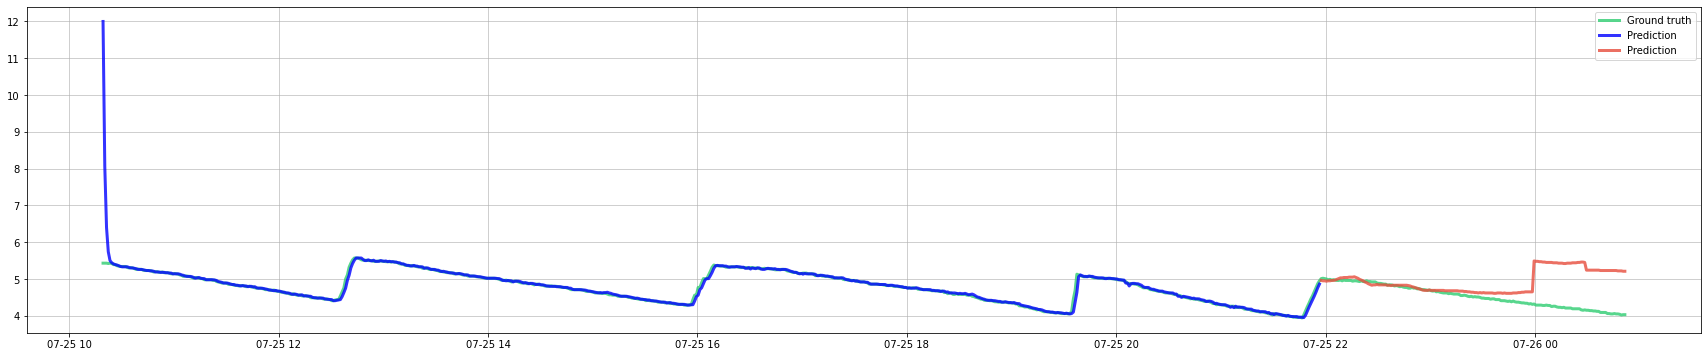

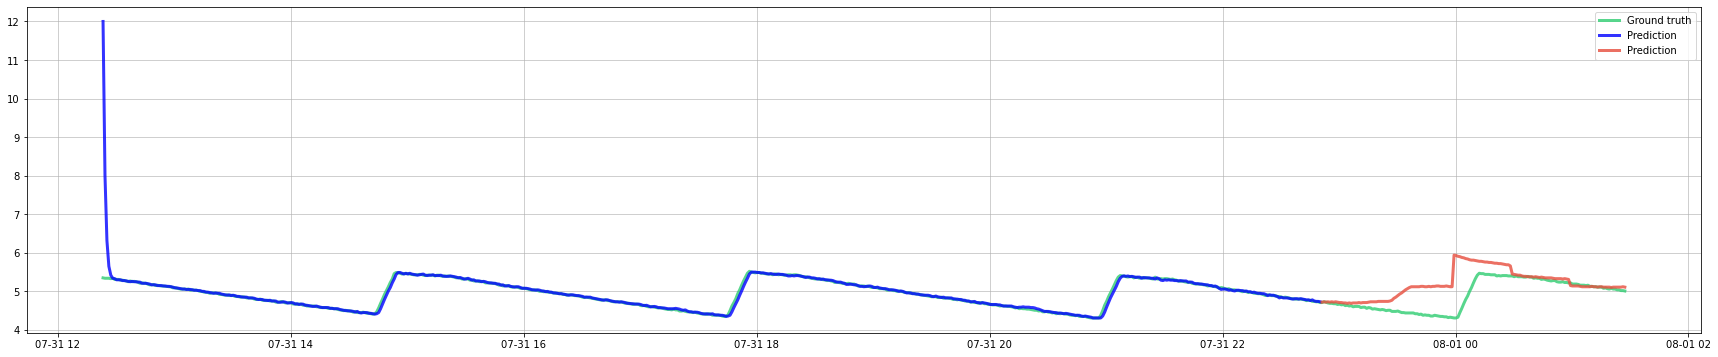

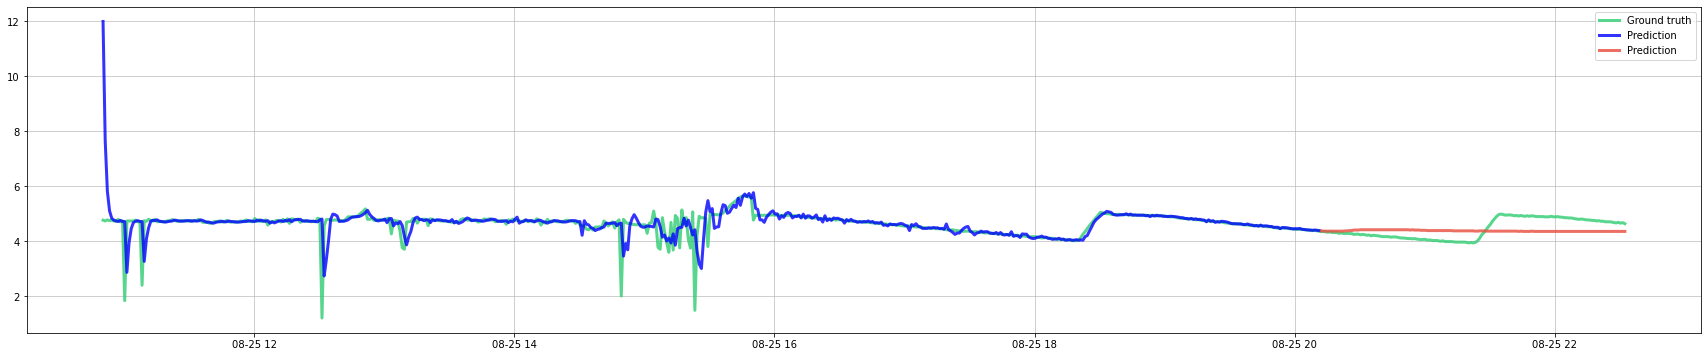

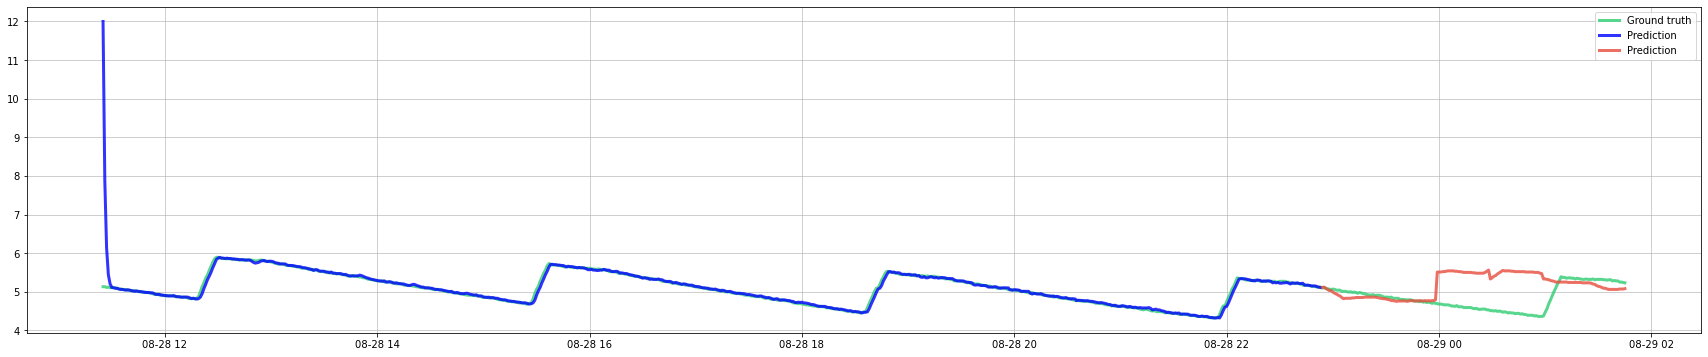

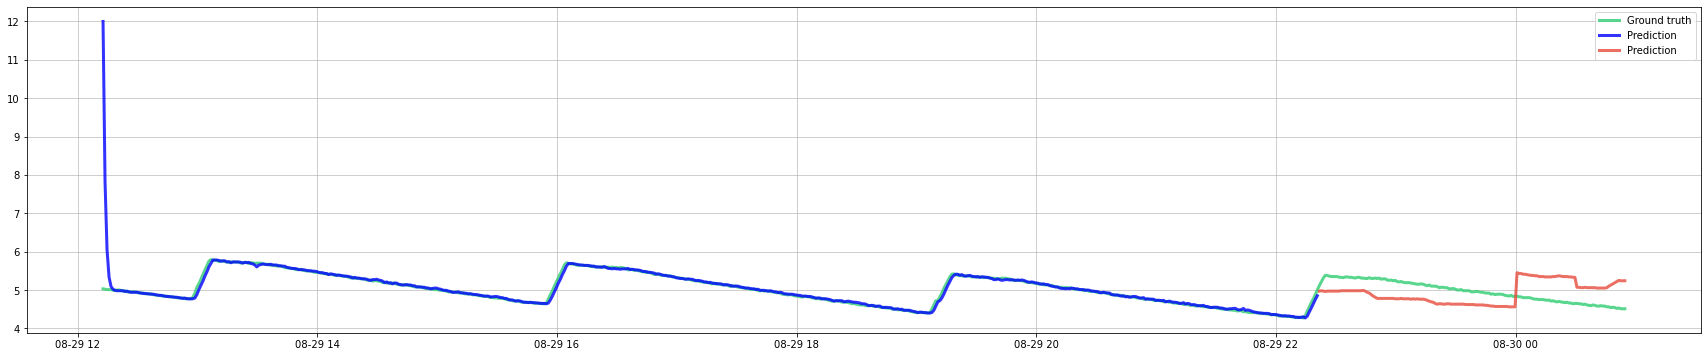

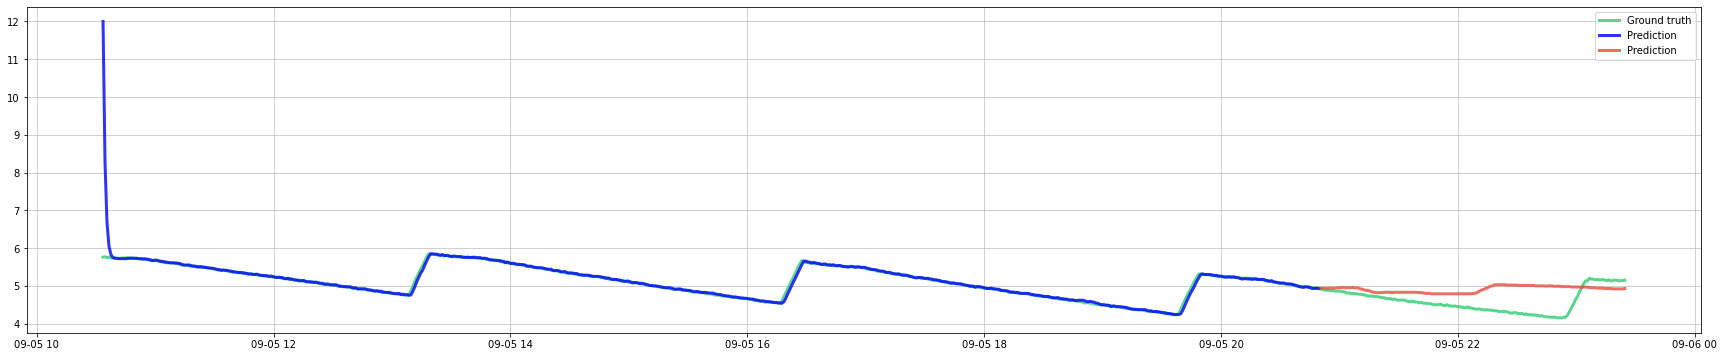

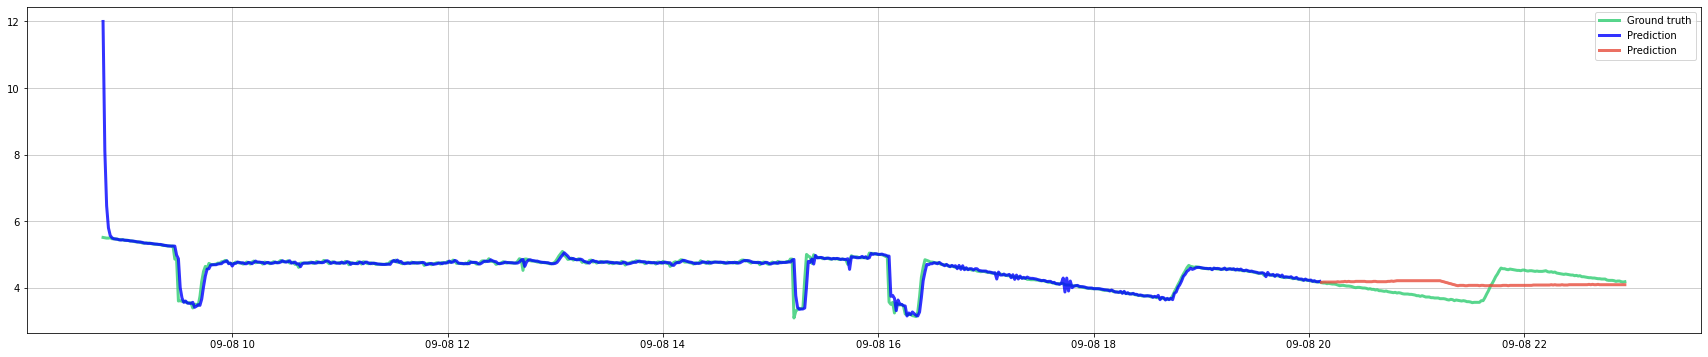

In [11]:
for nombreFichero in listFicheros_sensor2051:
    
    modelo = Modelo_SNARIMAX(2051)
                          
    modelo.inicializar(p = 0, 
                         d = 0, 
                         q = 2, 
                         m = 30, 
                         sp = 6, 
                         sq = 10, 
                         intercept_init = 12, 
                         sgd = 0.01,
                         intercerpt_lr = 0.3)
    
    sensor = pd.read_csv('C:\\Datos_prueba\\'+ nombreFichero +'', index_col=['timestamp'], parse_dates=['timestamp'])
    pruebas_regresion(modelo, sensor)
       

### sensor Presión tubería de agua

histData2052_2021-07-24_2021-07-25.csv | MSE: 0.018 	 RMSE: 0.135 	 MAE: 0.109 	 R2: -0.424 

histData2052_2021-07-31_2021-08-01.csv | MSE: 0.058 	 RMSE: 0.242 	 MAE: 0.200 	 R2: -2.509 

histData2052_2021-08-25_2021-08-26.csv | MSE: 340427.461 	 RMSE: 583.462 	 MAE: 459.975 	 R2: -0.016 

histData2052_2021-08-27_2021-08-28.csv | MSE: 0.055 	 RMSE: 0.234 	 MAE: 0.192 	 R2: -0.177 

histData2052_2021-08-28_2021-08-29.csv | MSE: 0.063 	 RMSE: 0.250 	 MAE: 0.209 	 R2: -1.304 

histData2052_2021-09-05_2021-09-06.csv | MSE: 0.064 	 RMSE: 0.254 	 MAE: 0.192 	 R2: -1.165 

histData2052_2021-09-08_2021-09-09.csv | MSE: 1220.508 	 RMSE: 34.936 	 MAE: 33.953 	 R2: -29187.444 



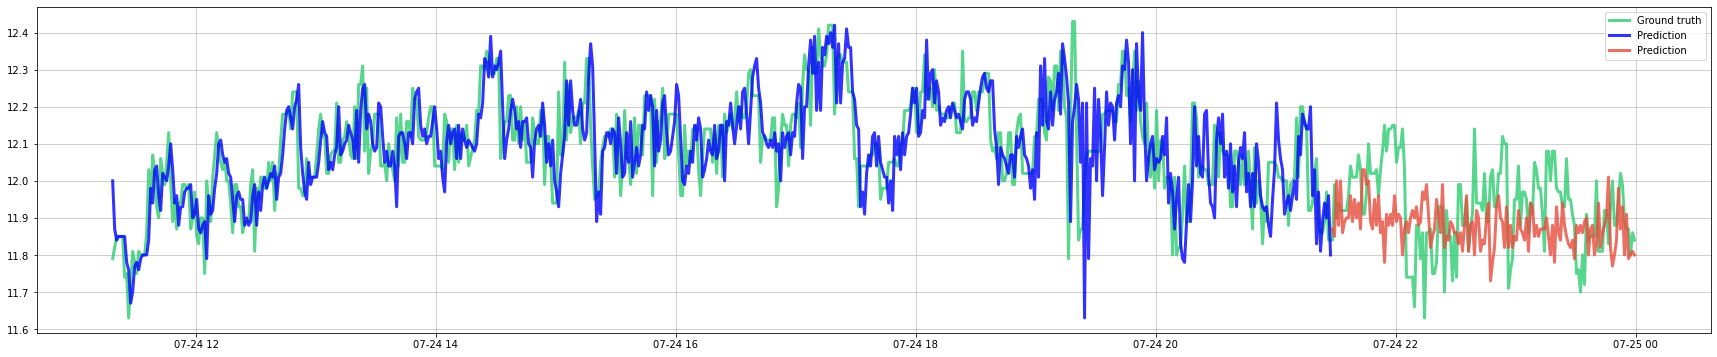

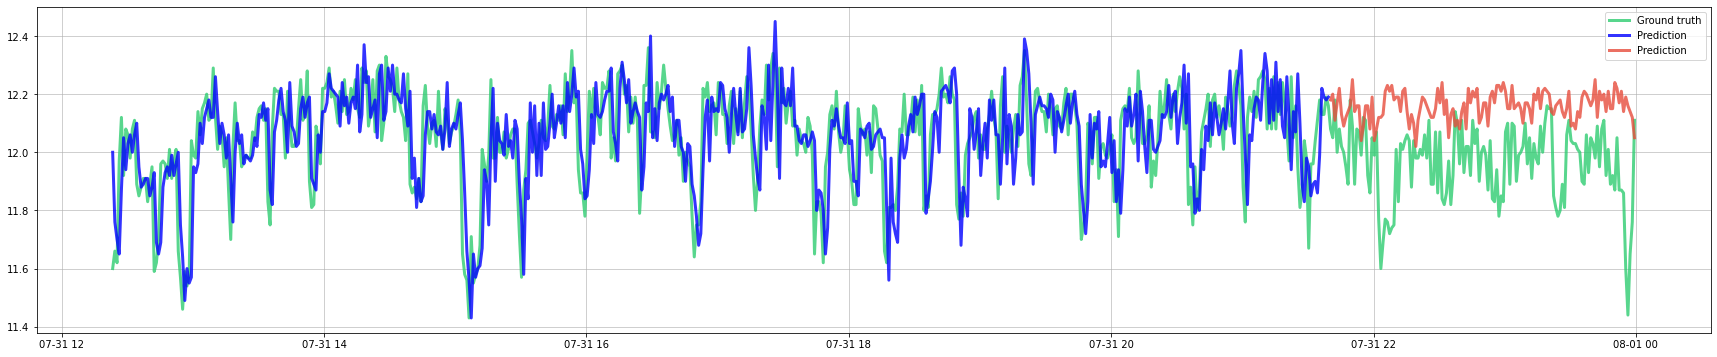

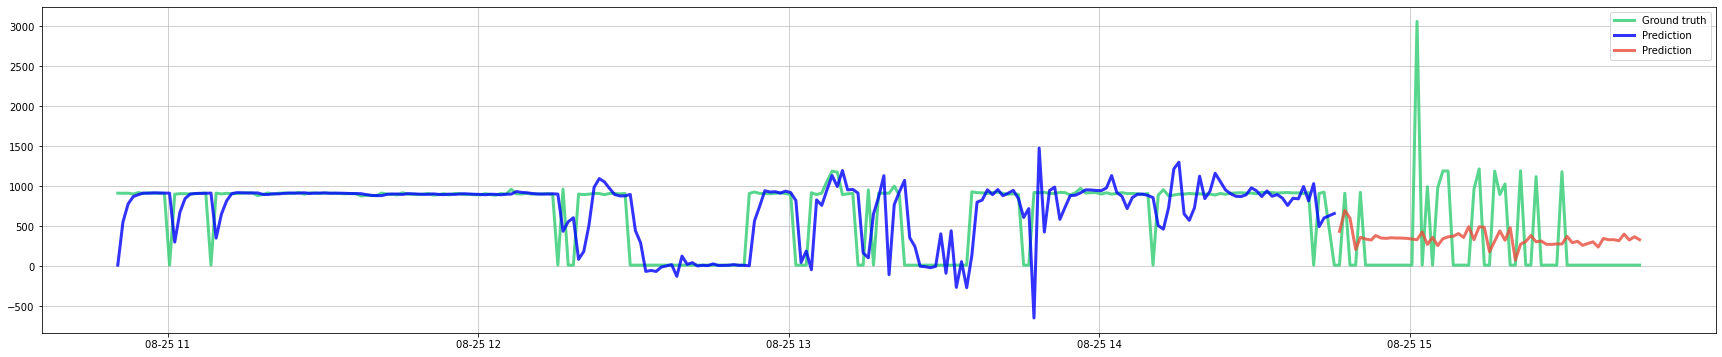

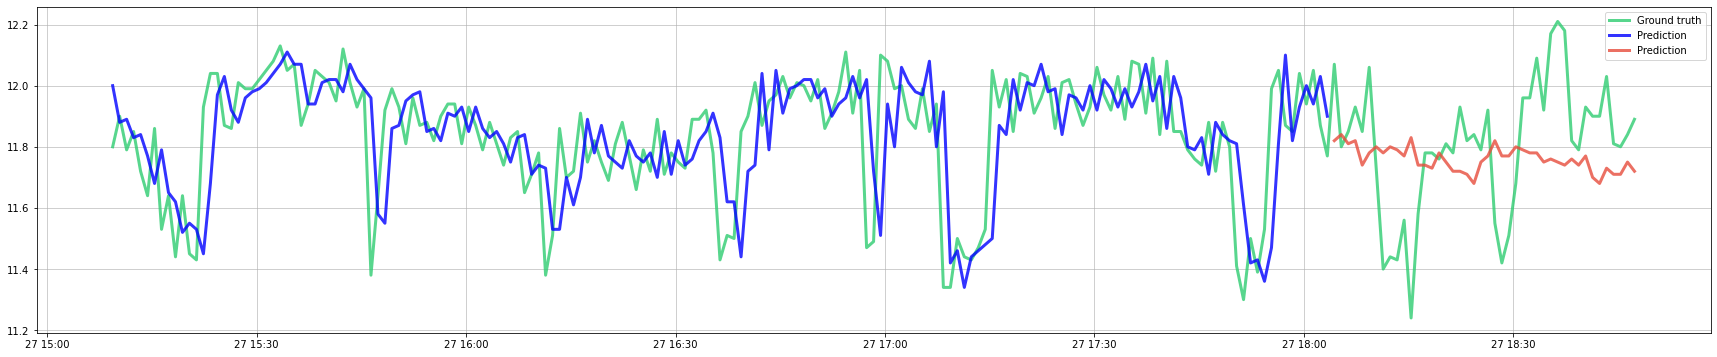

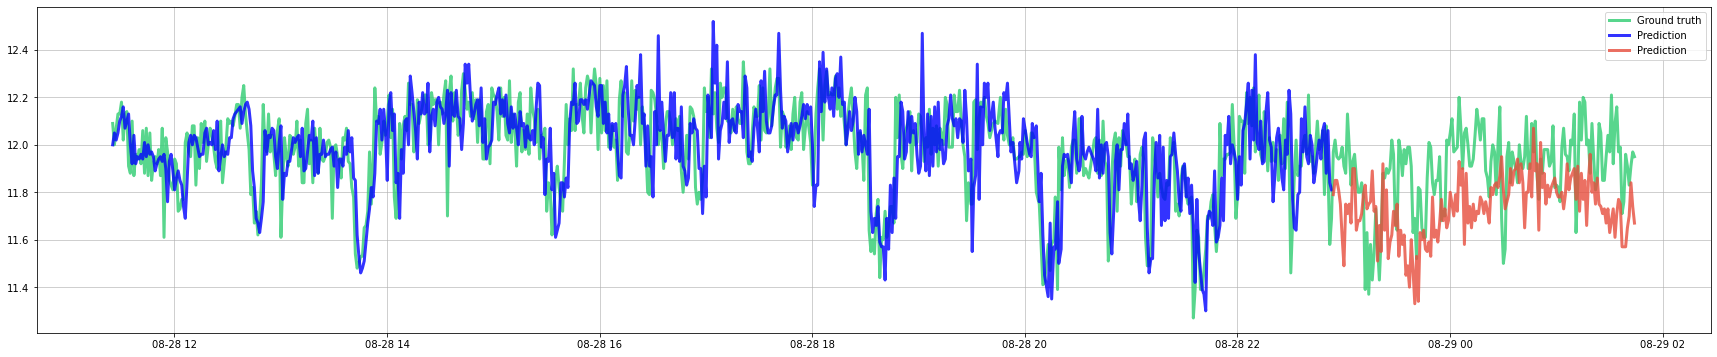

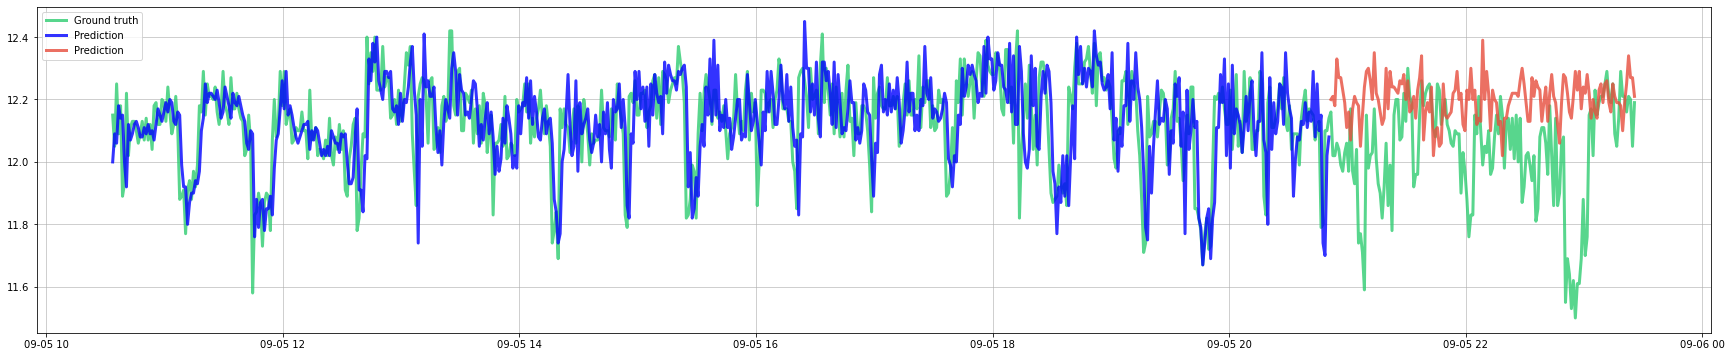

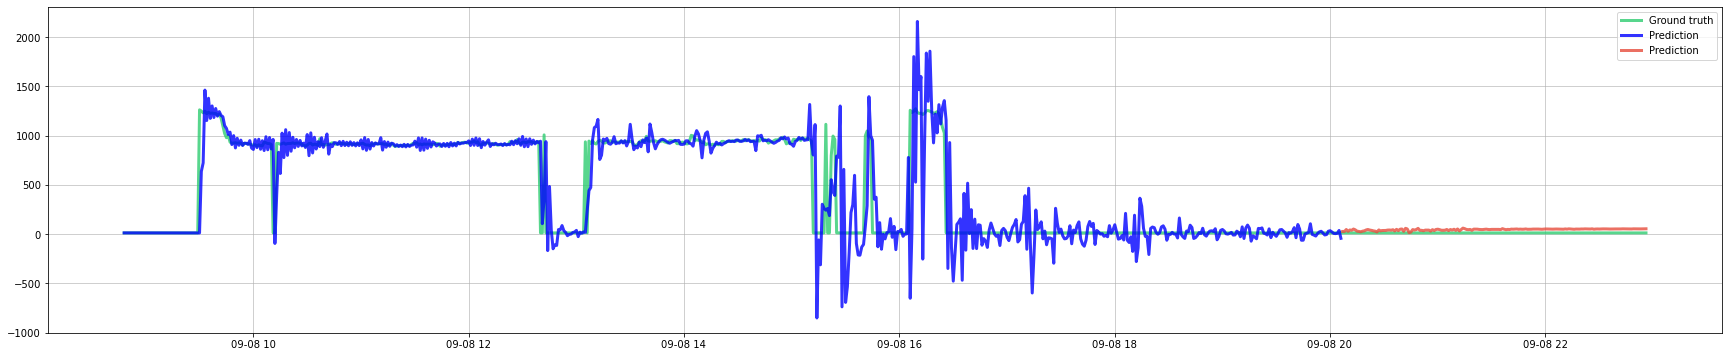

In [15]:

for nombreFichero in listFicheros_sensor2052:
    
    modelo = Modelo_SNARIMAX(2052)
                          
    modelo.inicializar(p = 0, 
                         d = 0, 
                         q = 2, 
                         m = 30, 
                         sp = 6, 
                         sq = 10, 
                         intercept_init = 12, 
                         sgd = 0.01,
                         intercerpt_lr = 0.3)

    
    sensor = pd.read_csv('C:\\Datos_prueba\\'+ nombreFichero +'', index_col=['timestamp'], parse_dates=['timestamp'])
    pruebas_regresion(modelo, sensor)


## Pruebas con conjuntos de datos más grandes

https://www.kaggle.com/nphantawee/pump-sensor-data



In [66]:
listaDataset=["dataset1.csv","dataset2.csv","dataset3.csv", "dataset4.csv"]

dataset1.csv | MSE: 2.883 	 RMSE: 1.698 	 MAE: 1.213 	 R2: -0.055 

dataset2.csv | MSE: 1.719 	 RMSE: 1.311 	 MAE: 1.005 	 R2: -0.115 

dataset3.csv | MSE: 1.613 	 RMSE: 1.270 	 MAE: 0.982 	 R2: -0.287 

dataset4.csv | MSE: 130.277 	 RMSE: 11.414 	 MAE: 7.697 	 R2: -0.428 



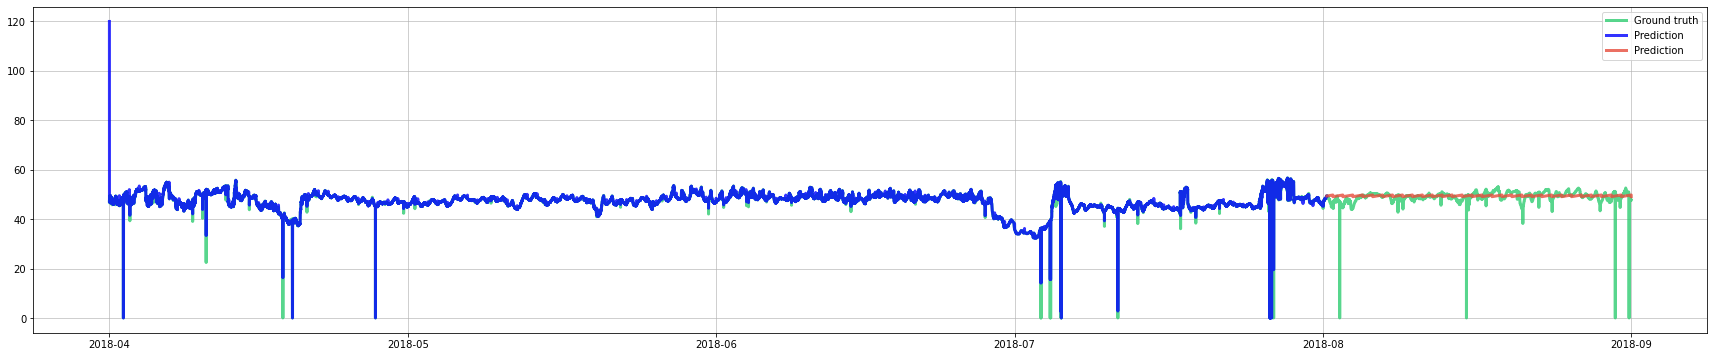

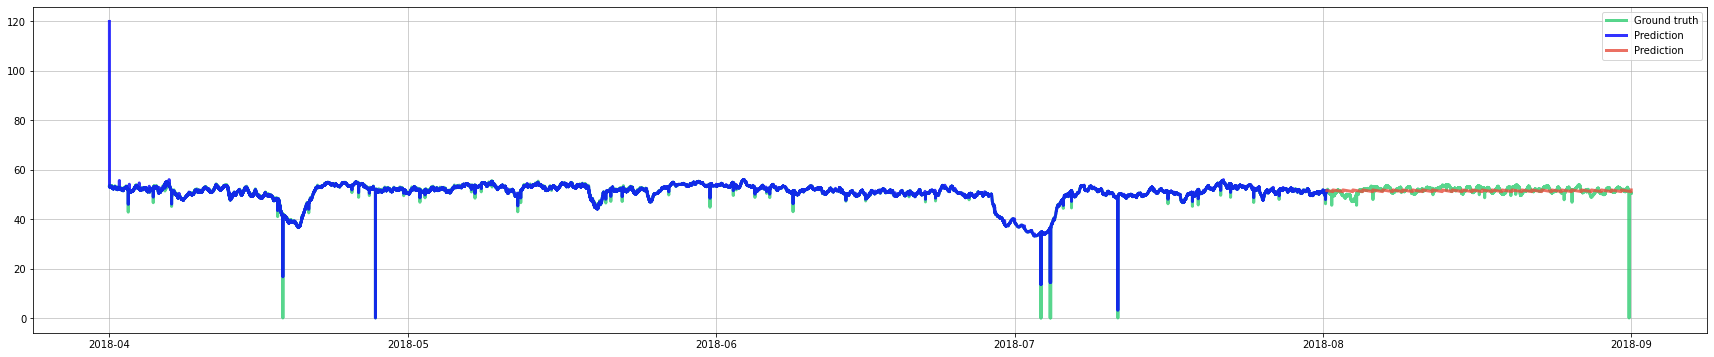

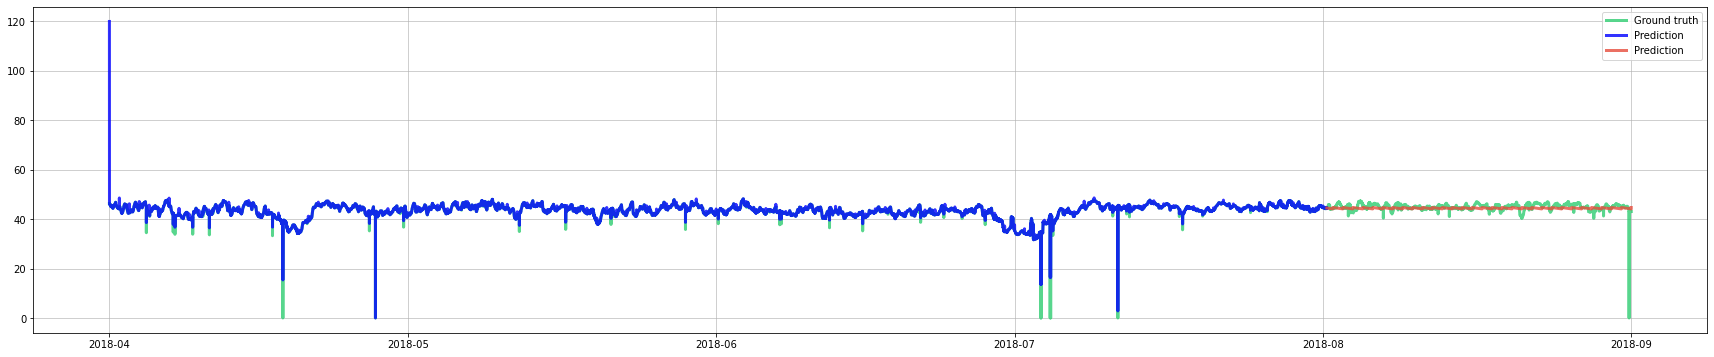

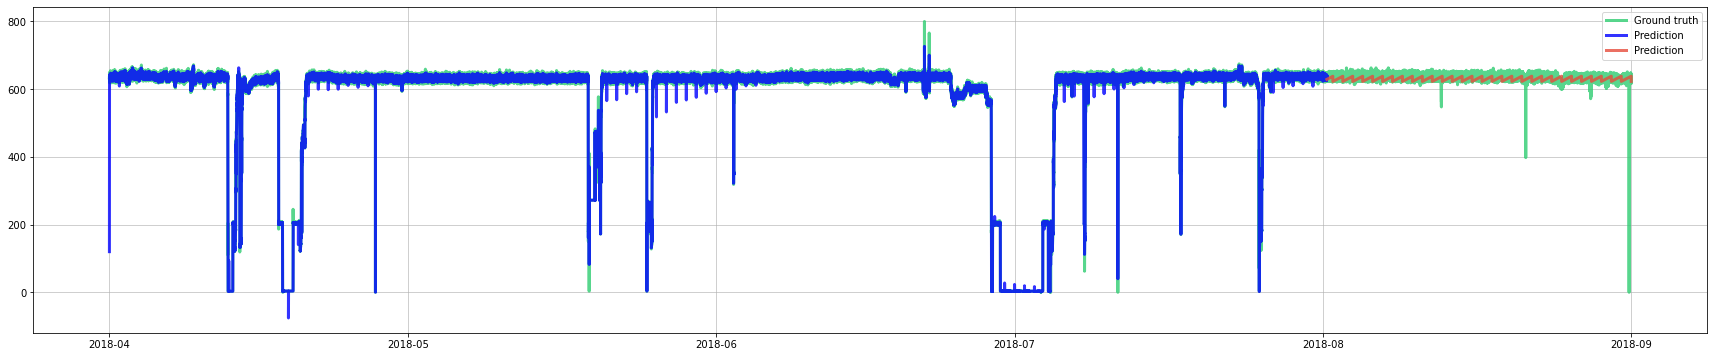

In [67]:
for nombreFichero in listaDataset:
    modelo = Modelo_SNARIMAX(2052)
                          
    modelo.inicializar(p = 0, 
                         d = 0, 
                         q = 0, 
                         m = 20, 
                         sp = 1, 
                         sq = 1, 
                         intercept_init = 120, 
                         sgd = 0.01,
                         intercerpt_lr = 0.3)

    sensor = pd.read_csv('C:\\Datos_prueba\\' + nombreFichero + '', index_col=['timestamp'], parse_dates=['timestamp'])
    pruebas_regresion(modelo, sensor)